https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/
https://habr.com/ru/company/joom/blog/445354/

In [1]:
from pathlib import Path
import os
import random

import cv2
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN

from sklearn.metrics import pairwise_distances

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)

Device is: cpu


In [4]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Planes/Airplanes_Annotations.zip" -d "/content/" &> /dev/null
!unzip "/content/drive/MyDrive/Colab Notebooks/Planes/Images.zip" -d "/content/" &> /dev/null

In [5]:
DRIVE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/Planes/'

IMAGES_FOLDER = 'Images'
ANNOT_FOLDER = 'Airplanes_Annotations' 

In [6]:
def visualize(filename: str):
    img = cv2.imread(str(Path(IMAGES_FOLDER, filename + '.jpg')))
    annot = pd.read_csv(Path(ANNOT_FOLDER, filename + '.csv'))
    plt.imshow(img)
    for _, row in annot.iterrows():
        x1, y1, x2, y2 = map(int, row[0].split(' '))
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    plt.figure()
    plt.imshow(img)

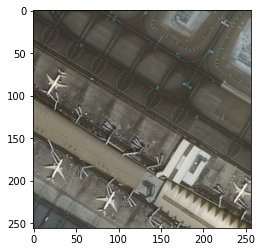

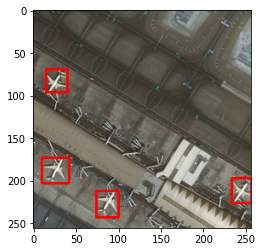

In [7]:
visualize('42845')

In [12]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True, progress=True, num_classes=91, pretrained_backbone=True
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [13]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
full_img_fmaps = torch.load(DRIVE_FOLDER + 'tensors_full_img/output_tensors.pt', map_location='cpu')

for fmap in full_img_fmaps:
    print(fmap.shape)

torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 100, 100])
torch.Size([1, 256, 50, 50])
torch.Size([1, 256, 25, 25])
torch.Size([1, 256, 13, 13])


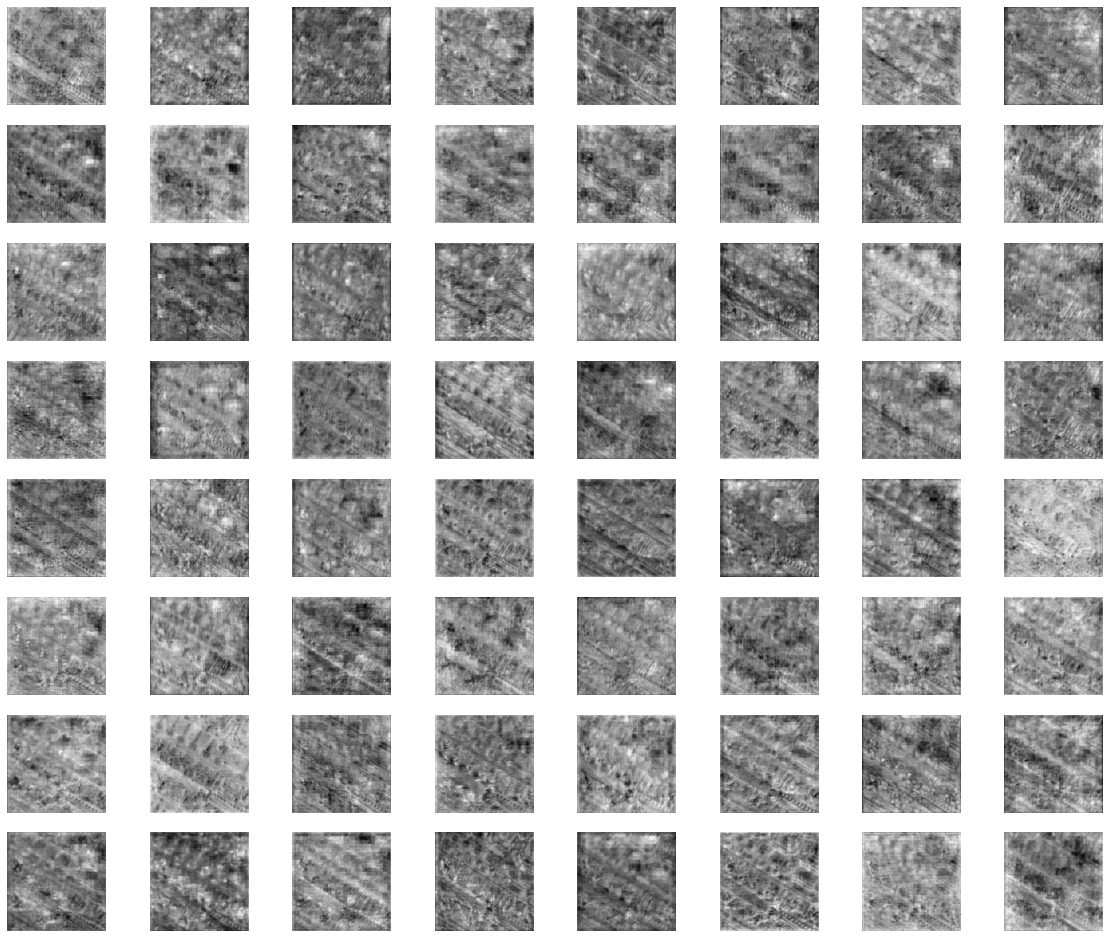

In [15]:
plt.figure(figsize=(20, 17))

# visualize first 64 maps from 1st (largest) FPN output tensor
for i, fmap in enumerate(full_img_fmaps[0].squeeze(0)[:64], 1):
    plt.subplot(8, 8, i)
    plt.imshow(fmap.detach().cpu(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# GETTING OUTPUT OF FPN (last maxpool layer)

# fpn_output = None

# def get_output_from_fpn(self, input, output):
#     global fpn_output
#     fpn_output = output[0]

# hook_pool = model.backbone.fpn.extra_blocks.register_forward_hook(get_output_from_fpn)

In [ ]:
# IMG OF INTEREST INFERENCE

# img_path = Path(DRIVE_FOLDER, '42845_plane.jpg')

# to_tensor = transforms.ToTensor()

# def val_transform(img):
#     img_tensor = to_tensor(img)
#     return img_tensor.unsqueeze(0)

# img_tensor = val_transform(Image.open(img_path))
# print('img_tensor:', img_tensor.shape)

# model.to(device)
# model.eval()
# with torch.no_grad():
#     model(img_tensor.to(device))

# torch.save(fpn_output, Path(DRIVE_FOLDER, 'tensors_interest_img/output_tensors.pt'))

img_tensor: torch.Size([1, 3, 41, 39])


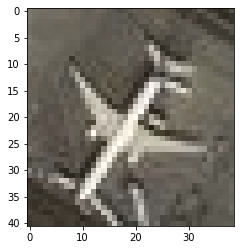

In [40]:
# IMAGE OF INTEREST

img = cv2.imread(str(Path(DRIVE_FOLDER, '42845_plane.jpg')))
plt.imshow(img);

In [21]:
fpn_output = torch.load(Path(DRIVE_FOLDER, 'tensors_interest_img/output_tensors.pt'), map_location='cpu')

for output_tensor in fpn_output:
    print(output_tensor.size())

torch.Size([1, 256, 216, 200])
torch.Size([1, 256, 108, 100])
torch.Size([1, 256, 54, 50])
torch.Size([1, 256, 27, 25])
torch.Size([1, 256, 14, 13])


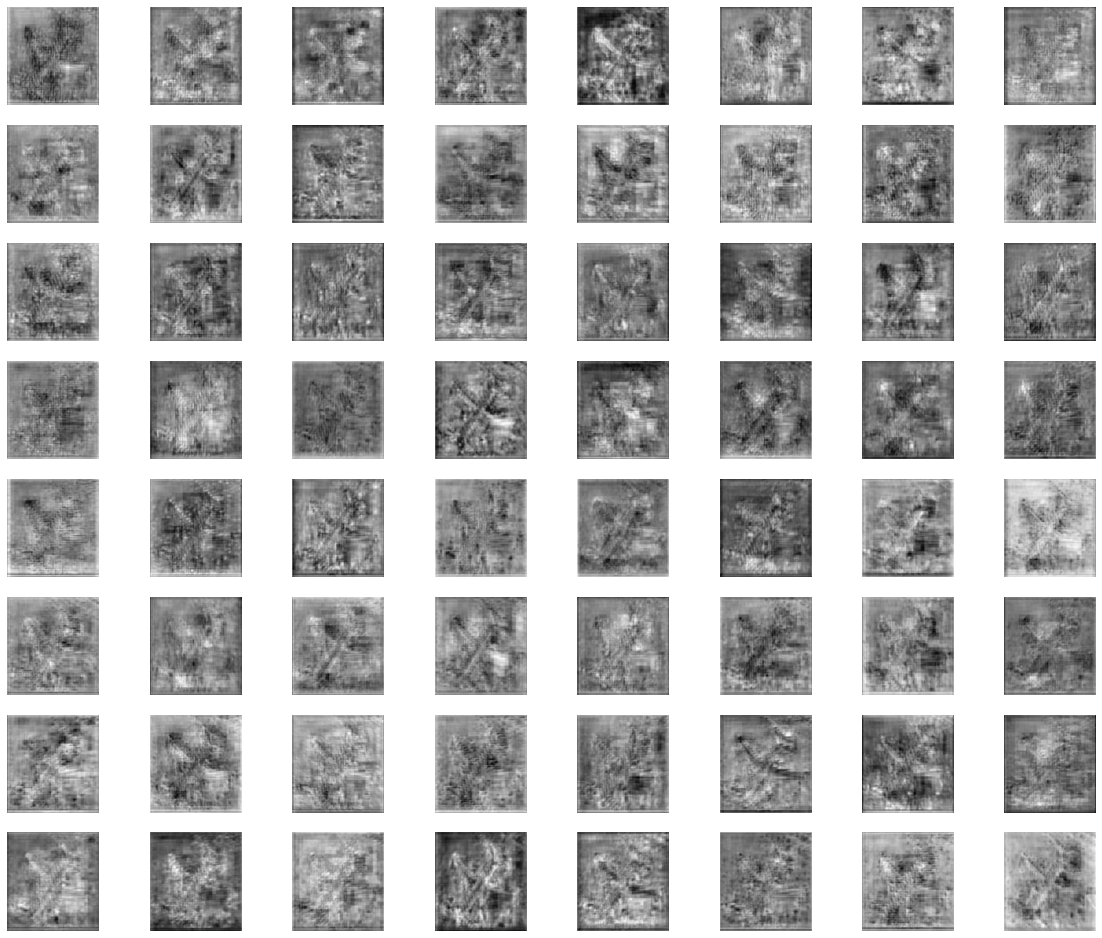

In [22]:
plt.figure(figsize=(20, 17))

# visualize first 64 maps from 1st (largest) FPN output tensor
for i, fmap in enumerate(fpn_output[0].squeeze(0)[:64], 1):
    plt.subplot(8, 8, i)
    plt.imshow(fmap.detach().cpu(), cmap='gray')
    plt.axis('off')
plt.show()

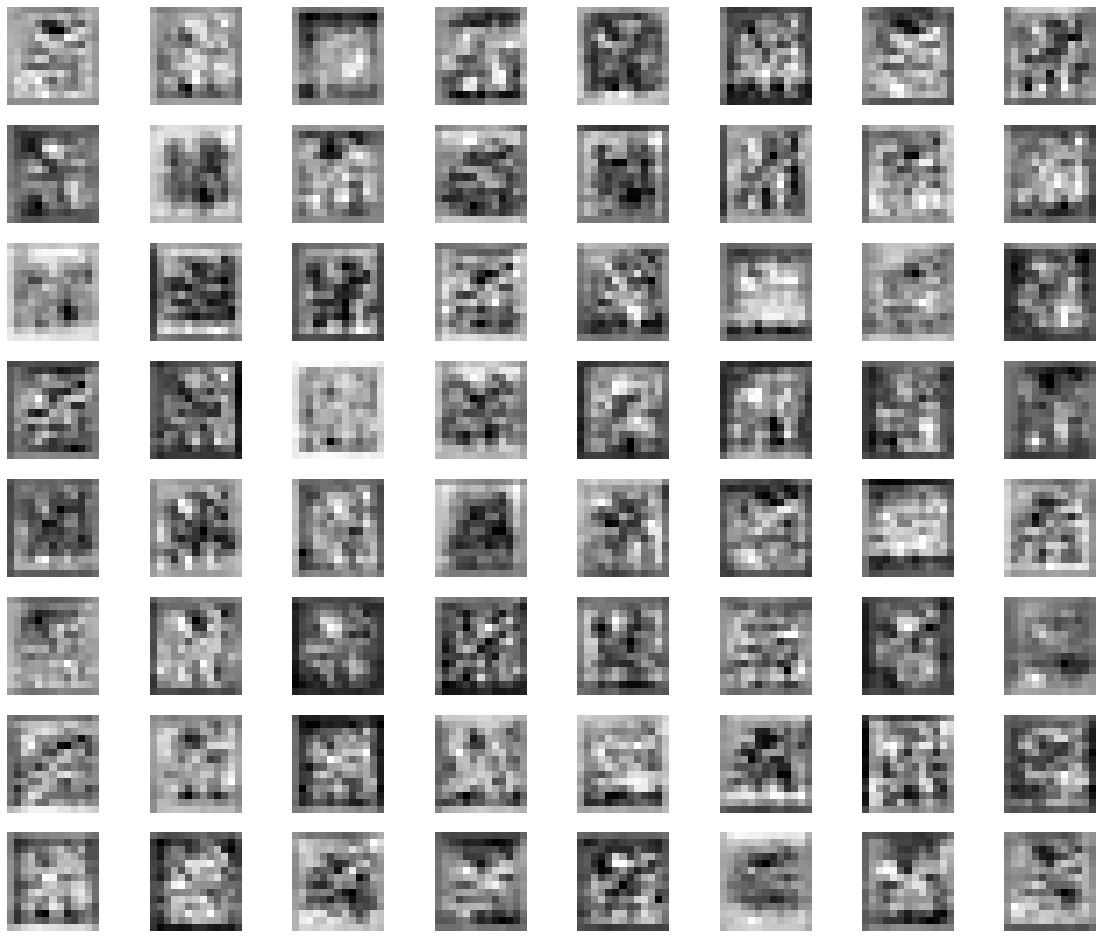

In [23]:
plt.figure(figsize=(20, 17))

# visualize first 64 maps from last (smallest) FPN output tensor
for i, fmap in enumerate(fpn_output[-1].squeeze(0)[:64], 1):
    plt.subplot(8, 8, i)
    plt.imshow(fmap.detach().cpu(), cmap='gray')
    plt.axis('off')
plt.show()

In [24]:
def get_patches(tensor: torch.Tensor, kernel: int, stride: int) -> torch.Tensor:
    """
    Extract windows (patches) from tensor.
    """
    assert len(tensor.shape) == 3  # C x H x W
    patches = tensor.unfold(1, kernel, stride).unfold(2, kernel, stride)
    patches = patches.reshape(-1, tensor.shape[0], kernel, kernel)
    return patches

In [25]:
def calc_distance(tensor1: torch.Tensor, tensor2: torch.Tensor) -> np.ndarray:
    assert len(tensor1.shape) == len(tensor2.shape) == 3  # C x H x W
    assert tensor1.shape[0] == tensor2.shape[0]
    channels = tensor1.shape[0]
    dst = pairwise_distances(
        tensor1.reshape([channels, -1]).t().cpu(), 
        tensor2.reshape([channels, -1]).t().cpu(), 
        metric='cosine',
        # n_jobs=-1
    )  # [tensor1.shape[1] * tensor1.shape[2] x tensor2.shape[1] * tensor2.shape[2]]
    dst = np.mean(dst, 1)  # [tensor1.shape[1] * tensor1.shape[2] x 1]
    dst = dst.reshape(tuple(tensor1.shape[-2:]))  # [tensor1.shape[1] x tensor1.shape[2]]
    return dst

In [27]:
# GET PATCHES (3x3 WINDOWS) FROM IMAGE OF INTEREST

KERNEL = 3
STRIDE = 2

patches_collection = [
    get_patches(fpn_output[i].squeeze(0), KERNEL, STRIDE) 
    for i in range(len(fpn_output))
]

for patches in patches_collection:
    print(patches.shape)

torch.Size([10593, 256, 3, 3])
torch.Size([2597, 256, 3, 3])
torch.Size([624, 256, 3, 3])
torch.Size([156, 256, 3, 3])
torch.Size([36, 256, 3, 3])


In [ ]:
# CALCULATE DISTINCES BETWEEN FULL IMAGE AND PATCHES/WINDOWS FROM IMAGE OF INTEREST
# (takes very looong...)

# patches_dst_collection = []

# for i, patches in enumerate(patches_collection):
#     patches_dst = []

#     full_img_fmaps_ = full_img_fmaps[i].squeeze(0)

#     print(f'{patches.shape} against {full_img_fmaps_.shape}')

#     for wn in patches:
#         patches_dst.append(calc_distance(full_img_fmaps_, wn))
    
#     patches_dst_collection.append(patches_dst)

torch.Size([10593, 256, 3, 3]) against torch.Size([256, 200, 200])
torch.Size([2597, 256, 3, 3]) against torch.Size([256, 100, 100])
torch.Size([624, 256, 3, 3]) against torch.Size([256, 50, 50])
torch.Size([156, 256, 3, 3]) against torch.Size([256, 25, 25])
torch.Size([36, 256, 3, 3]) against torch.Size([256, 13, 13])


In [ ]:
# for x in patches_dst_collection:
#     x = torch.Tensor(np.array(x))
#     print(x.shape)
#     torch.save(x, Path(DRIVE_FOLDER, f'tensors_dst/tensor_dst_{x.shape[0]}.pt'))

torch.Size([10593, 200, 200])
torch.Size([2597, 100, 100])
torch.Size([624, 50, 50])
torch.Size([156, 25, 25])
torch.Size([36, 13, 13])


In [29]:
patches_dst_collection = []

for filename in os.listdir(Path(DRIVE_FOLDER, 'tensors_dst')):
    tensor_ = torch.load(Path(DRIVE_FOLDER, 'tensors_dst', filename), map_location='cpu')
    patches_dst_collection.append(tensor_)
    print(tensor_.shape)

torch.Size([10593, 200, 200])
torch.Size([2597, 100, 100])
torch.Size([624, 50, 50])
torch.Size([156, 25, 25])
torch.Size([36, 13, 13])


In [37]:
mean_dst_collection = [x_dst.mean(dim=0) for x_dst in patches_dst_collection]

for mean_dst in mean_dst_collection:
    print(mean_dst.shape)

torch.Size([200, 200])
torch.Size([100, 100])
torch.Size([50, 50])
torch.Size([25, 25])
torch.Size([13, 13])


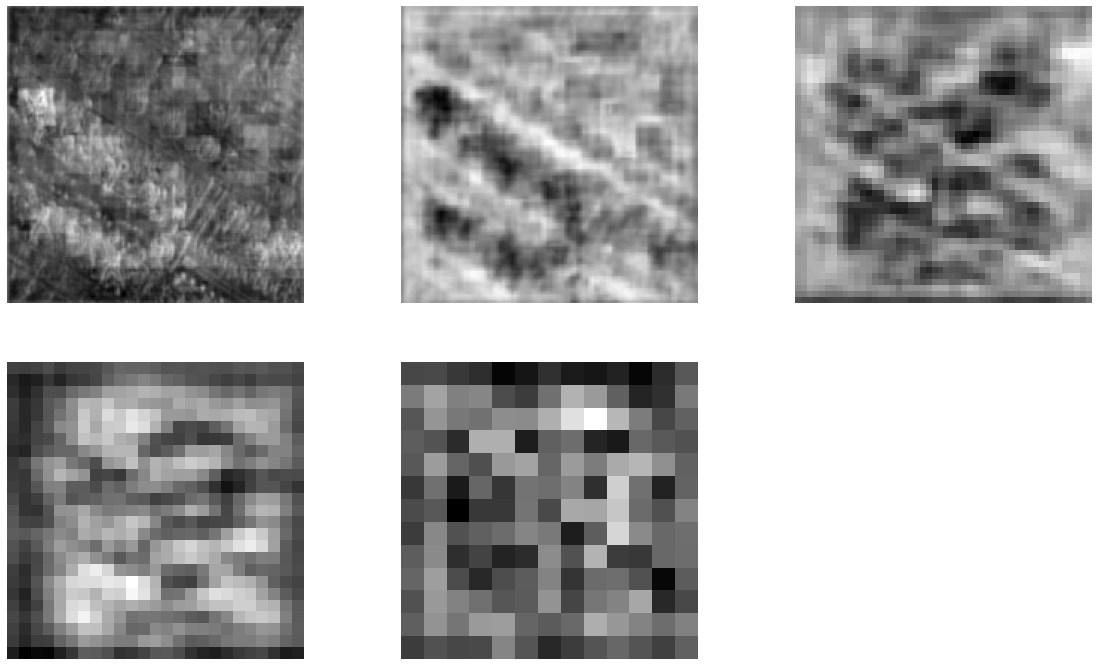

In [38]:
# why 1st, 4th, 5th are white spots on black background, and 2nd and 3rd are black spots on white background?

plt.figure(figsize=(20, 12))
for i, x in enumerate(mean_dst_collection, 1):
    plt.subplot(2, 3, i)
    plt.imshow(x.numpy(), cmap='gray')
    plt.axis('off')
plt.show()

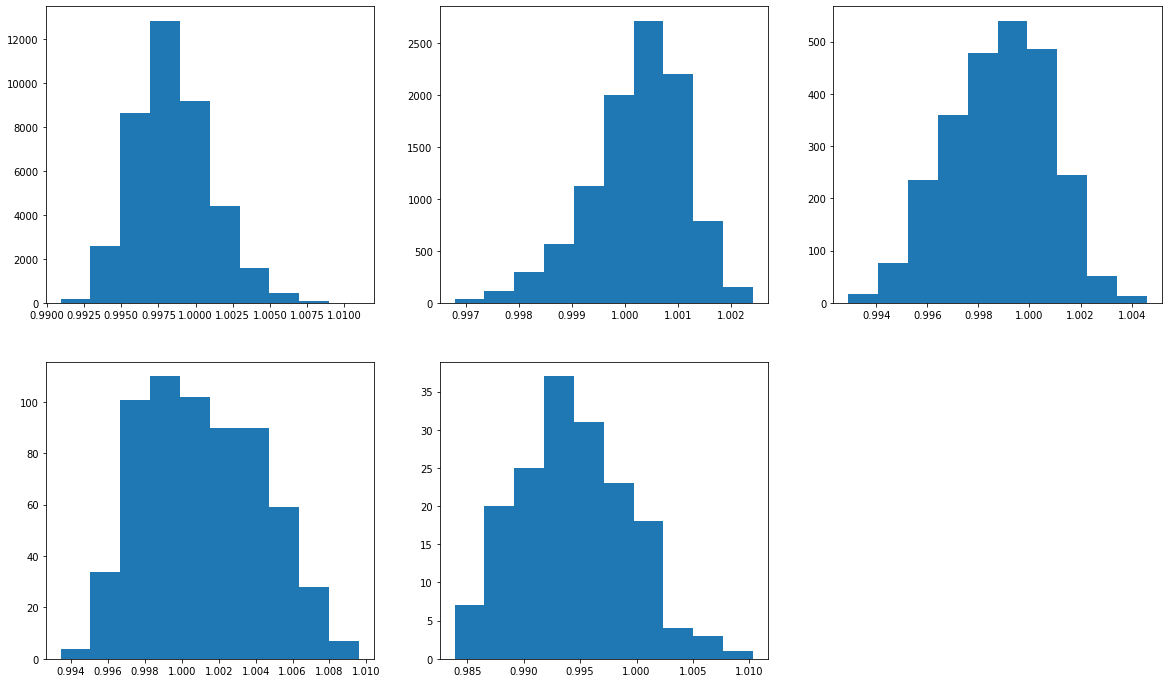

In [49]:
plt.figure(figsize=(20, 12))
for i, x in enumerate(mean_dst_collection, 1):
    plt.subplot(2, 3, i)
    plt.hist(x.reshape(-1).numpy())
plt.show()